https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

image sharpness  - `dst = cv2.detailEnhance(src, sigma_s=10, sigma_r=0.15)`

camera gain
```
cv::VideoCapture::set(CV_CAP_PROP_EXPOSURE, value from 0 to 1)
cv::VideoCapture::set(CV_CAP_PROP_GAIN, value from 0 to 1)
```

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")  # Append pieye module root to sys.path

import cv2
import IPython.display as ipython
import numpy as np
from PIL import Image

# from pieye.video import play
from pieye.utils import bounding_boxes

In [3]:
import os
import threading
from time import sleep
from typing import Tuple

from libcamera import controls
from picamera2 import Picamera2


class VideoCapture(threading.Thread):
    def __init__(self, cam):
        super().__init__()
        self.cam = cam
        self.frame = None
        self.capture = False
    
    def run(self):
        try:
            while self.capture:
                self.frame = self.cam.capture_array()
        finally:
            pass

    def start(self):
        self.capture = True

        # There are three autoFocus modes: Manual, Auto, and Continuous
        self.cam.set_controls({"AfMode": controls.AfModeEnum.Continuous})
        # for auto: success = picam2.autofocus_cycle() to trigger focus cycle.
        # e.g. 
        # job = picam2.autofocus_cycle(wait=False)
        # Now do some other things, and when you finally want to be sure the autofocus cycle is finished:
        # success = picam2.wait(job)
        self.cam.start()
        sleep(1)  # delay for starting the cam
        super().start()
    
    def stop(self):
        self.capture = False
        self.join()
        self.cam.stop()


class Camera():
    def __init__(self, resolution: Tuple = (320, 320)):
        self.cam = Picamera2()
        # Picamera2.create_preview_configuration will generate a configuration suitable for displaying camera preview images on the display, or prior to capturing a still image
        # Picamera2.create_still_configuration will generate a configuration suitable for capturing a high-resolution still image
        # Picamera2.create_video_configuration will generate a configuration suitable for recording video files
        self.cam.configure(self.cam.create_preview_configuration(main={"format": 'RGB888', "size": resolution}))
        # self.cap.set(cv2.CAP_PROP_EXPOSURE, 0.5)
        # capture.set(cv2.CAP_PROP_AUTO_EXPOSURE, 3) # auto mode
        # capture.set(cv2.CAP_PROP_AUTO_EXPOSURE, 1) # manual mode
        # capture.set(cv2.CAP_PROP_EXPOSURE, desired_exposure_value)

        self.video_capture = None
    
    def start(self):
        self.stop()
        self.video_capture = VideoCapture(self.cam)
        self.video_capture.start()

    def stop(self):
        if self.video_capture is not None:
            self.video_capture.stop()
            self.video_capture = None

    def get_frame(self):
        if self.video_capture is not None:
            return self.video_capture.frame
        else:
            return None


    # def __enter__(self)
    # def __exit__(self, exc_type, exc_value, traceback)

In [4]:
cam = Camera()

[0:17:14.496488172] [3707]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[0:17:14.548167860] [3735]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:17:14.550119201] [3735]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media0 and ISP device /dev/media1
[0:17:14.550172571] [3735]  INFO RPI pipeline_base.cpp:1125 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:17:14.558689658] [3707]  INFO Camera camera.cpp:1191 configuring streams: (0) 320x320-RGB888 (1) 1536x864-SBGGR10_CSI2P
[0:17:14.559123178] [3735]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SBGGR10_1X10 - Selected unicam format: 1536x864-pBAA


In [5]:
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F

detection_threshold = 0.5
preprocess_no_normalize = transforms.Compose([
    # convert the frame to a CHW torch tensor
    transforms.ToTensor(),
])
# Load object detection model. TODO: Need to quantize manually
model = models.detection.ssdlite320_mobilenet_v3_large(weights=models.detection.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
model = model.eval()

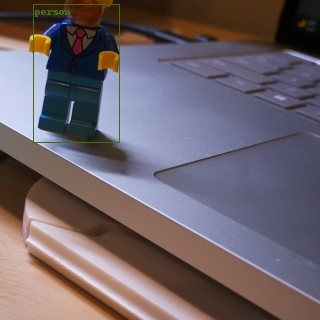

In [25]:
display_handle = ipython.display(None, display_id=True)

run_inference = True

try:
    cam.start()
    while True:
        frame = cam.get_frame()
        if frame is not None:
            if run_inference:
                input_tensor = preprocess_no_normalize(frame)
                input_batch = input_tensor.unsqueeze(0)
                with torch.no_grad():
                    # TODO: too slow. Use different thread for inference.
                    outputs = model(input_batch)
                    bbox = bounding_boxes(input_tensor, outputs)
                    frame = np.array(F.to_pil_image(bbox))

            _, img = cv2.imencode('.jpeg', frame)
            display_handle.update(ipython.Image(data=img.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    cam.stop()

In [ ]:
# For focus: https://forums.raspberrypi.com/viewtopic.php?t=342993
# https://www.arducam.com/raspberry-pi-camera/autofocus/
# import os
# focus = 500
# ...
# os.system("v4l2-ctl -d /dev/v4l-subdev1 -c focus_absolute=" + str(focus))
# rpistr = "libcamera-vid -t 0 --segment 1  --codec mjpeg -n -o /run/shm/test%06d.jpg --width " + str(wx) + " --height " + str(hx)
   
